<a href="https://colab.research.google.com/github/Mindauskas/iWild/blob/master/iWildcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The notebook for iWildCam 2019 - FGVC6 image classification (https://www.kaggle.com/c/iwildcam-2019-fgvc6)

In [0]:
!pip install -q -U toai
!pip install -U kaggle

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [0]:
def setup_kaggle():
  !mkdir /root/.kaggle
  !mv kaggle.json /root/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json

In [0]:
setup_kaggle()

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
__import__('toai').__version__

'0.1.25'

In [0]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [0]:
%matplotlib inline
from toai.imports import *
from toai.data import Dataset, DataParams, DataContainer
from toai.models import save_keras_model, load_keras_model
from toai.metrics import sparse_top_2_categorical_accuracy
from toai.image import (
    ImageLearner,
    ImageAugmentor,
    ImageDataset,
    ImageParser,
    ImageResizer,
    LearningRateFinder,
    ImageTrainingCycle,
    ImageTrainer,
)
from toai.utils import download_file, unzip, save_file, load_file
import tensorflow as tf
from tensorflow import keras

In [0]:
tf.enable_eager_execution()

**Download data from Kaggle**

In [0]:
os.getcwd()

'/content'

In [0]:
kaggle.api.authenticate()
kaggle.api.competition_download_files(
    competition='iwildcam-2019-fgvc6',
    path='competition_files',
    force=False,
    quiet=False)

  0%|          | 9.00M/43.4G [00:00<08:29, 91.5MB/s]

100%|██████████| 43.4G/43.4G [04:00<00:00, 194MB/s]

In [0]:
%cd competition_files/

/content/competition_files


In [0]:
!unzip iwildcam-2019-fgvc6.zip

Archive:  iwildcam-2019-fgvc6.zip
  inflating: train_images.zip        
  inflating: train.csv               
  inflating: test_images.zip         
  inflating: sample_submission.csv   
  inflating: test.csv                


In [0]:
!rm iwildcam-2019-fgvc6.zip

In [0]:
!mkdir train
!unzip -qq train_images.zip -d train
!rm train_images.zip

In [0]:
!mkdir test
!unzip -qq test_images.zip -d test
!rm test_images.zip

In [0]:
train_labels = pd.read_csv('train.csv')

In [0]:
train_labels.shape

(196299, 11)

In [0]:
train_labels.head(5)

,category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747
1,19,2012-03-17 03:48:44,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,2,588a679f-23d2-11e8-a6a3-ec086b02610b,115,Justin Brown,6f12067d-5567-11e8-b3c0-dca9047ef277,3,1024,747
2,0,2014-05-11 11:56:46,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,1,59279ce3-23d2-11e8-a6a3-ec086b02610b,96,Erin Boydston,6faa92d1-5567-11e8-b1ae-dca9047ef277,1,1024,747
3,0,2013-10-06 02:00:00,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,1,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,57,Erin Boydston,6f7d4702-5567-11e8-9e03-dca9047ef277,1,1024,747
4,0,2011-07-12 13:11:16,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg,3,599fbd89-23d2-11e8-a6a3-ec086b02610b,46,Justin Brown,6f1728a1-5567-11e8-9be7-dca9047ef277,3,1024,747


In [0]:
train_labels.category_id.value_counts(dropna=False)

0     131457
19     14106
13      8623
11      7209
8       6938
1       6102
16      5975
17      4759
3       3398
18      3035
4       2210
14      1361
10      1093
22        33
Name: category_id, dtype: int64

Some labels do not exist in training dataset (e.g. 2,5, etc.)!

**Creating folder for each category**

In [0]:
!mkdir train_data_in_folders

In [0]:
def make_dir(target):
  if not os.path.exists(target):
    os.mkdir(target)
  return target

In [0]:
def split_to_folders(train_labels_df, source, destination):
  dir_data = Path(source)
  for _, row in train_labels_df.iterrows():
    file_name = row.file_name
    category_id = row.category_id
    target_dest = make_dir(Path(destination)/str(category_id))
    try:
      shutil.move('./'+source+'/'+file_name, target_dest)
    except Exception as e:
      print(e)

In [0]:
split_to_folders(train_labels,'train','train_data_in_folders')

Destination path 'train_data_in_folders/16/5858c2ed-23d2-11e8-a6a3-ec086b02610b.jpg' already exists
[Errno 2] No such file or directory: './train/5858c2ed-23d2-11e8-a6a3-ec086b02610b.jpg'
[Errno 2] No such file or directory: './train/5858c2ed-23d2-11e8-a6a3-ec086b02610b.jpg'
Destination path 'train_data_in_folders/16/5919977e-23d2-11e8-a6a3-ec086b02610b.jpg' already exists
[Errno 2] No such file or directory: './train/5919977e-23d2-11e8-a6a3-ec086b02610b.jpg'
[Errno 2] No such file or directory: './train/5919977e-23d2-11e8-a6a3-ec086b02610b.jpg'
Destination path 'train_data_in_folders/16/5892b57f-23d2-11e8-a6a3-ec086b02610b.jpg' already exists
[Errno 2] No such file or directory: './train/5892b57f-23d2-11e8-a6a3-ec086b02610b.jpg'
[Errno 2] No such file or directory: './train/5892b57f-23d2-11e8-a6a3-ec086b02610b.jpg'
Destination path 'train_data_in_folders/16/58fd7e46-23d2-11e8-a6a3-ec086b02610b.jpg' already exists
[Errno 2] No such file or directory: './train/58fd7e46-23d2-11e8-a6a3-ec

**Load data from subfolders**

In [0]:
train_labels[train_labels.file_name == '58d930f0-23d2-11e8-a6a3-ec086b02610b.jpg']

,category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height
54243,8,2012-05-23 05:24:12,58d930f0-23d2-11e8-a6a3-ec086b02610b.jpg,2,58d930f0-23d2-11e8-a6a3-ec086b02610b,130,Justin Brown,6f0d87d1-5567-11e8-8daa-dca9047ef277,3,1024,747
54244,8,2012-05-23 05:24:12,58d930f0-23d2-11e8-a6a3-ec086b02610b.jpg,2,58d930f0-23d2-11e8-a6a3-ec086b02610b,130,Justin Brown,6f0d87d1-5567-11e8-8daa-dca9047ef277,3,1024,747
54245,16,2012-05-23 05:24:12,58d930f0-23d2-11e8-a6a3-ec086b02610b.jpg,2,58d930f0-23d2-11e8-a6a3-ec086b02610b,130,Justin Brown,6f0d87d1-5567-11e8-8daa-dca9047ef277,3,1024,747
54246,16,2012-05-23 05:24:12,58d930f0-23d2-11e8-a6a3-ec086b02610b.jpg,2,58d930f0-23d2-11e8-a6a3-ec086b02610b,130,Justin Brown,6f0d87d1-5567-11e8-8daa-dca9047ef277,3,1024,747


**Model**

In [0]:
IMG_DIMS = (100, 100, 3)

In [0]:
train_data, valid_data, test_data = ImageDataset.split(
    dataset=ImageDataset.from_subfolders('./train_data_in_folders/'),
    fracs=(0.8, 0.1, 0.1),
)

In [0]:
!pwd

/content/competition_files


In [0]:
train_data = (
    train_data
    .dataset(batch_size=32, img_dims=IMG_DIMS, shuffle=True)
    .make_pipeline(
        image_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="crop", crop_adjustment=1),
            ImageAugmentor(level=3, flips="both"),
        ],
    )
    .save_pipeline('./train_files')
    .preprocess()
)

In [0]:
valid_data = (
    valid_data
    .dataset(batch_size=1, img_dims=IMG_DIMS, shuffle=False)
    .make_pipeline(
        label_map=train_data.label_map,
        image_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
        ],
    )
    .save_pipeline('./valid_files')
    .preprocess()
)

In [0]:
test_data = (
    test_data
    .dataset(batch_size=1, img_dims=IMG_DIMS, shuffle=False)
    .load_pipeline('./valid_files')
    .preprocess()
)

In [0]:
train_data.label_map

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '13': 4,
 '14': 5,
 '16': 6,
 '17': 7,
 '18': 8,
 '19': 9,
 '22': 10,
 '3': 11,
 '4': 12,
 '8': 13}

In [0]:
valid_data.label_map

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '13': 4,
 '14': 5,
 '16': 6,
 '17': 7,
 '18': 8,
 '19': 9,
 '22': 10,
 '3': 11,
 '4': 12,
 '8': 13}

In [0]:
test_data.label_map

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '13': 4,
 '14': 5,
 '16': 6,
 '17': 7,
 '18': 8,
 '19': 9,
 '22': 10,
 '3': 11,
 '4': 12,
 '8': 13}

In [0]:
len(train_data), len(valid_data), len(test_data)

(156869, 19609, 19608)

In [0]:
data_container = DataContainer(
    train=train_data,
    validation=valid_data,
    test=test_data,
)

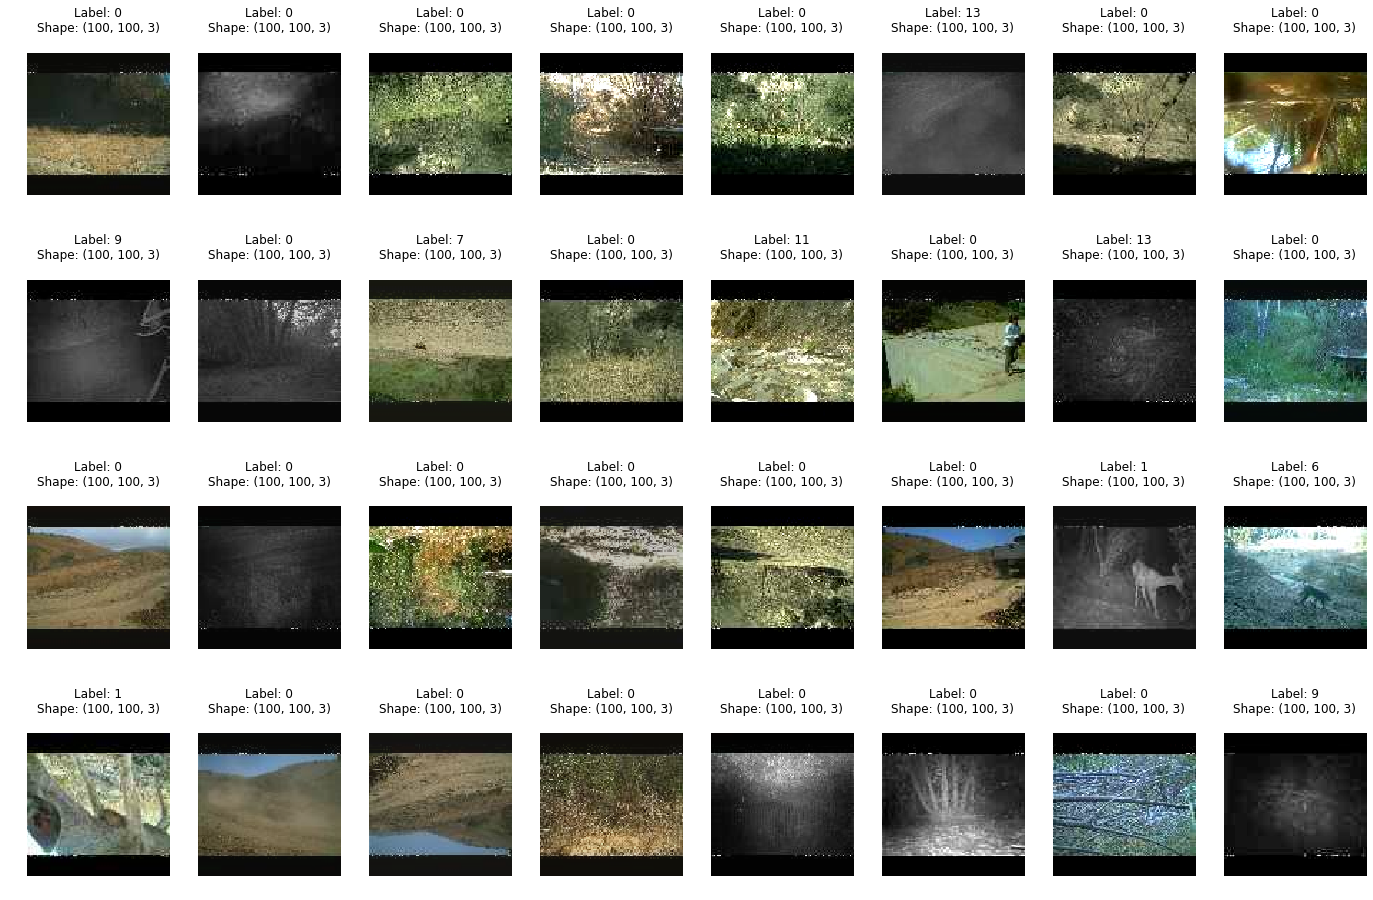

In [0]:
data_container.train.show(debug=True)

In [0]:
#data_container.validation.show()

In [0]:
#data_container.test.show()

In [0]:
learner_xception = ImageLearner(
    path='./Xception',
    base_model=keras.applications.Xception,
    input_shape=(IMG_DIMS),
    output_shape=[data_container.train.n_classes],
    activation=keras.activations.softmax,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[keras.metrics.sparse_categorical_accuracy, sparse_top_2_categorical_accuracy],
    dropout=0.5,
    l1=3e-6,
    l2=3e-5,
    load=True,
)

83689472/83683744 [==============================] - 1s 0us/step


In [0]:
trainer = ImageTrainer(
    learner=learner_xception,
    data_container=data_container,
    cycles=[
            ImageTrainingCycle(
        n_epochs=5,
        lr=3e-5,
        optimizer=keras.optimizers.Adam,
        feature_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
            ImageAugmentor(level=1),
        ],
    ),
    ],
)

In [0]:
trainer.train()

Train for 4903 steps, validate for 19609 steps
Epoch 1/5
4903/4903 [==============================] - 2425s 495ms/step - loss: 0.9155 - sparse_categorical_accuracy: 0.7727 - sparse_top_2_categorical_accuracy: 0.8444 - val_loss: 0.4701 - val_sparse_categorical_accuracy: 0.8557 - val_sparse_top_2_categorical_accuracy: 0.9238
Epoch 2/5
4903/4903 [==============================] - 1659s 338ms/step - loss: 0.4277 - sparse_categorical_accuracy: 0.8700 - sparse_top_2_categorical_accuracy: 0.9339 - val_loss: 0.3317 - val_sparse_categorical_accuracy: 0.8936 - val_sparse_top_2_categorical_accuracy: 0.9499
Epoch 3/5
4903/4903 [==============================] - 1662s 339ms/step - loss: 0.2904 - sparse_categorical_accuracy: 0.9078 - sparse_top_2_categorical_accuracy: 0.9604 - val_loss: 0.2635 - val_sparse_categorical_accuracy: 0.9142 - val_sparse_top_2_categorical_accuracy: 0.9644
Epoch 4/5
4903/4903 [==============================] - 1655s 338ms/step - loss: 0.2132 - sparse_categorical_accuracy: 0

In [0]:
trainer.evaluate_dataset()

19609/19609 [==============================] - 333s 17ms/step - loss: 0.2260 - sparse_categorical_accuracy: 0.9302 - sparse_top_2_categorical_accuracy: 0.9747


[0.22595276479916648, 0.93018514, 0.9747055]

In [0]:
trainer.predict_dataset()

array([[9.9967253e-01, 6.7371919e-05, 9.7296916e-06, ..., 1.5408626e-05,
        3.9777722e-05, 3.0052986e-05],
       [9.9972409e-01, 4.1622068e-05, 1.2181419e-05, ..., 1.0972027e-05,
        7.1584553e-05, 7.9010868e-05],
       [2.1522290e-05, 2.0719133e-05, 2.4123068e-05, ..., 7.1760878e-05,
        5.5724574e-04, 4.2302799e-04],
       ...,
       [1.8184579e-09, 9.9994433e-01, 1.6361272e-06, ..., 5.5463652e-06,
        3.5372072e-06, 5.7806301e-07],
       [9.9985933e-01, 3.8483267e-06, 8.1692360e-06, ..., 6.9978647e-05,
        2.2874010e-05, 1.3129740e-05],
       [9.2865199e-01, 2.4922196e-02, 5.8176508e-04, ..., 1.4171760e-04,
        2.0986212e-04, 5.0633569e-04]], dtype=float32)

In [0]:
trainer.analyse_dataset()

,path,image,label,label_code,pred,pred_code,label_probs,pred_probs
0,train_data_in_folders/0/58ef708b-23d2-11e8-a6a...,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0715293...",0,0,0,0,0.999673,0.999673
1,train_data_in_folders/0/58c0368a-23d2-11e8-a6a...,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0715293...",0,0,0,0,0.999724,0.999724
2,train_data_in_folders/19/59a49a5a-23d2-11e8-a6...,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0715293...",19,9,19,9,0.982689,0.982689
3,train_data_in_folders/0/5a096ba0-23d2-11e8-a6a...,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0715293...",0,0,0,0,0.999186,0.999186
4,train_data_in_folders/0/5937349e-23d2-11e8-a6a...,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0715293...",0,0,0,0,1.000000,1.000000
5,train_data_in_folders/0/595f7bf5-23d2-11e8-a6a...,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0715293...",0,0,0,0,0.991072,0.991072
6,train_data_in_folders/0/58f8ce21-23d2-11e8-a6a...,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0715293...",0,0,0,0,0.999704,0.999704
7,train_data_in_folders/0/5a2637d9-23d2-11e8-a6a...,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0715293...",0,0,0,0,0.994897,0.994897
8,train_data_in_folders/0/5908813a-23d2-11e8-a6a...,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0715293...",0,0,0,0,0.999701,0.999701
9,train_data_in_folders/0/59da8aaa-23d2-11e8-a6a...,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0715293...",0,0,0,0,0.999439,0.999439


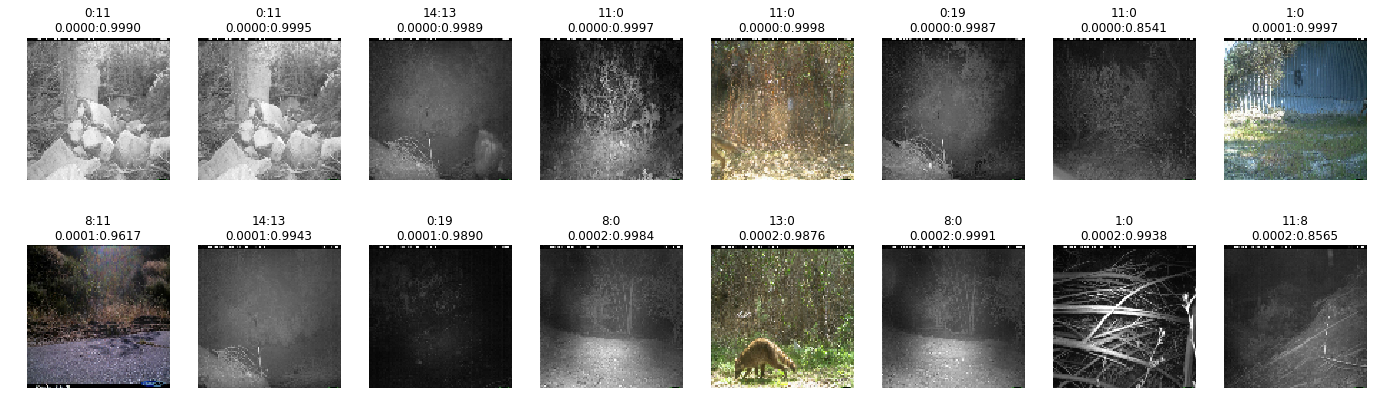

In [0]:
trainer.show_predictions()